# Procrastinate Pro+ Business Performance Analysis

In this project, a marketing analysis of the reasons for the loss of the entertainment application Procrastinate Pro + is carried out. Despite huge investments in advertising, the company has been losing money for the past few months.

# Purpose of the study

Understand the reasons for the drop in profits and help the company become profitable.

# Research objectives

* channels to attract users;
* what devices users use;
* how much it costs to attract users from various advertising channels;
* how much money each client brings;
* when the cost of attracting a client pays off;
* what factors interfere with attracting customers.

# Initial data

We have the following data on users referred from May 1 to October 27, 2019:
* server log with data about their visits;
* unloading their purchases for this period;
* advertising expenses

# 1. Review the data

We import all the necessary libraries for working with data.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [46]:
try:
    df_visits = pd.read_csv(r'D:\Yandex_Data_Analysis\Project_6\visits_info_short.csv')
except:
    df_visits = pd.read_csv('/datasets/visits_info_short.csv')
try:
    df_orders = pd.read_csv(r'D:\Yandex_Data_Analysis\Project_6\orders_info_short.csv')
except:
    df_orders = pd.read_csv('/datasets/orders_info_short.csv')
try:
    df_costs = pd.read_csv(r'D:\Yandex_Data_Analysis\Project_6\costs_info_short.csv')
except:
    df_costs = pd.read_csv('/datasets/costs_info_short.csv')

Let's look at the original data tables.

In [47]:
display(df_visits.head(5),
        df_orders.head(5),
        df_costs.head(5))

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

dt   Channel  costs
0  2019-05-01  FaceBoom 113.30
1  2019-05-02  FaceBoom  78.10
2  2019-05-03  FaceBoom  85.80
3  2019-05-04  FaceBoom 136.40
4  2019-05-05  FaceBoom 122.10

Let's look at the general information about the data in the tables.

In [48]:
print(df_visits.info(),
        df_orders.info(),
        df_costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   

As you can see, there are no missing values in any dataset.

# 2. Data preprocessing

Let's check the tables for obvious duplicates.

In [49]:
display(df_visits.duplicated().sum(),
        df_orders.duplicated().sum(),
        df_costs.duplicated().sum())

0

0

0

There are no duplicates.
Let's convert all column names to lower case, and replace spaces with underscores.

In [50]:
df_visits.columns = [x.lower().replace(' ', '_') for x in df_visits.columns]
df_orders.columns = [x.lower().replace(' ', '_') for x in df_orders.columns]
df_costs.columns = df_costs.columns.str.lower() 

Let's convert the date columns to the to_datetime format for further convenience.

In [51]:
df_visits['session_start'] = pd.to_datetime(df_visits['session_start'])
df_visits['session_end'] = pd.to_datetime(df_visits['session_end'])
df_orders['event_dt'] = pd.to_datetime(df_orders['event_dt'])
df_costs['dt'] = pd.to_datetime(df_costs['dt']).dt.date 

# 3. Functions for calculating and analyzing LTV, ROI, retention and conversion

## 3.1. Function for calculating LTV and ROI

In [52]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # exclude users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # add purchase data to profiles
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # calculate the user's lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # group by cohort if there is nothing in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # grouping function according to the desired features
    def group_by_dimensions(df, dims, horizon_days):
        # build a "triangular" revenue table
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # find the amount of revenue with accumulation
        result = result.fillna(0).cumsum(axis=1)
        # calculate cohort sizes
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # combine cohort sizes and revenue table
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # calculate LTV: divide each "cell" in the row by the size of the cohort
        result = result.div(result['cohort_size'], axis=0)
        # exclude all lifetimes that exceed the analysis horizon
        result = result[['cohort_size'] + list(range(horizon_days))]
        # restore cohort sizes
        result['cohort_size'] = cohort_sizes

        # collect dataframe with user data and CAC values,
        # adding parameters from dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

       # calculate the average CAC by parameters from dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # calculate ROI: divide LTV by CAC
        roi = result.div(cac['cac'], axis=0)

        # remove rows with infinite ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # restore cohort sizes in the ROI table
        roi['cohort_size'] = cohort_sizes

        # add CAC to ROI table
        roi['cac'] = cac['cac']

        # in the final table we leave the sizes of cohorts, CAC
        # and ROI in lifetimes that do not exceed the analysis horizon
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # return LTV and ROI tables
        return result, roi

    # get LTV and ROI tables
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # for dynamics tables remove 'cohort' from dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # get tables of LTV and ROI dynamics
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # raw data
        result_grouped,   # LTV table
        result_in_time,   # LTV dynamics table
        roi_grouped,  # ROI table
        roi_in_time,  # table of ROI dynamics
    ) 

## 3.2. Function to calculate retention

In [53]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # add the payer column to the passed dimensions list
    dimensions = ['payer'] + dimensions

     # exclude users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # collecting raw data to calculate retention
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # function for grouping the table according to the desired features
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # get hold table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # get a table of retention dynamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # return both tables and raw data
    return result_raw, result_grouped, result_in_time

## 3.3. Function for calculating conversion

In [54]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # exclude users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # determine the date and time of the first purchase for each user
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # add purchase data to profiles
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # calculate lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # group by cohort if there is nothing in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # function for grouping the table according to the desired features
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # divide each "cell" in the row by the size of the cohort
        # and get the conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # get the conversion table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # remove 'cohort' from dimensions for the conversion dynamics table
    if 'cohort' in dimensions: 
        dimensions = []

    # get a table of conversion dynamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # return both tables and raw data
    return result_raw, result_grouped, result_in_time

# 4. Exploratory Data Analysis

## 4.1. Determining the minimum and maximum user acquisition dates.

In [55]:
# moment of analysis
observation_date = datetime(2019, 11, 1).date()
observation_date

datetime.date(2019, 11, 1)

In [56]:
# analysis horizon
horizon_days = 14

In [57]:
# minimum user acquisition date
min_analysis_date = df_costs['dt'].min()
min_analysis_date

datetime.date(2019, 5, 1)

In [58]:
# the maximum possible date of attraction, taking into account the horizon
max_analysis_date= observation_date - timedelta(days=horizon_days - 1)
max_analysis_date

datetime.date(2019, 10, 19)

**Function to create custom profiles.**

In [59]:
def get_profiles(df_visits, df_orders, df_costs):
    # find the parameters of the first visits
    profiles = (
        df_visits.sort_values(by=['user_id', 'session_start'])
            .groupby('user_id')
            .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
            .rename(columns={'session_start': 'first_ts'})
            .reset_index()
    )

    # for cohort analysis, we determine the date of the first visit and the first day of the month in which this visit occurred
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # add a sign of paying users
    profiles['payer'] = profiles['user_id'].isin(df_orders['user_id'].unique())

    # count the number of unique users with the same source and acquisition date
    new_users = (
        profiles.groupby(['dt', 'channel'])
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'unique_users'})
            .reset_index()
    )

     # combine spending on advertising and the number of attracted users
    df_costs = df_costs.merge(new_users, on=['dt', 'channel'], how='left')
    # df_costs['acquisition_cost'] = df_costs.set_index('key').join(new_users.set_index('key'))

    # divide advertising costs by the number of attracted users
    df_costs['acquisition_cost'] = df_costs['costs'] / df_costs['unique_users']

    # add acquisition cost to profiles
    profiles = profiles.merge(
        df_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # organic user acquisition cost is zero
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


profiles = get_profiles(df_visits, df_orders, df_costs)
profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True              1.09  
1  2019-07-09 2019-07-01  False              1.11  
2  2019-10-01 2019-10-01  False              0.00  
3  2019-08-22 2019-08-01  False              0.99  
4  2019-10-02 2019-10-01  False              0.23

## 4.2. User countries and number of paying users.

In [60]:
profiles.groupby('region').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']}).sort_values(
    by=[('user_id', 'nunique')], ascending=False)


user_id payer     
              nunique   sum mean
region                          
United States  100002  6902 0.07
UK              17575   700 0.04
France          17450   663 0.04
Germany         14981   616 0.04

## 4.3. Popular devices.

In [61]:
device = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'sum'}).sort_values(by='payer', ascending=False)
device['share'] = round(device.payer / device.user_id, 2)
device

user_id  payer  share
device                        
iPhone     54479   3382   0.06
Android    35032   2050   0.06
Mac        30042   1912   0.06
PC         30455   1537   0.05

## 4.4. The most effective channels for attracting customers.

In [62]:
channel = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'sum'}).sort_values(by='payer', ascending=False)
channel['share'] = round(channel.payer / channel.user_id, 2)
channel

user_id  payer  share
channel                                  
FaceBoom              29144   3557   0.12
TipTop                19561   1878   0.10
organic               56439   1160   0.02
WahooNetBanner         8553    453   0.05
AdNonSense             3880    440   0.11
RocketSuperAds         4448    352   0.08
LeapBob                8553    262   0.03
OppleCreativeMedia     8605    233   0.03
lambdaMediaAds         2149    225   0.10
YRabbit                4312    165   0.04
MediaTornado           4364    156   0.04

In [63]:
print("Number of advertising sources -", len(channel))

Number of advertising sources - 11


## 4.5. Conclusion

According to the conditions of the task, we look at the data **November 1, 2019**. It is generally accepted in the company that payback should occur no later than **2 weeks** after attracting users. Thus, **analysis time** is November 1, 2019, **analysis horizon** is 14 days.

**Minimum user acquisition date is May 1, 2019. Horizontal maximum date is October 19, 2019**

Users come to the app from **4 countries**: USA, UK, France and Germany. **USA** leads by far in terms of the number of Procrastinate Pro+ app users (approximately 100k). Also, the share of paying users is higher in the US - 7%.

Customers use **devices** such as iPhone, Android, Mac and PC. The most popular device among all customers, including paying customers, is **iPhone**. The number of customers is 54.48 thousand, including 3.38 thousand paying users. The share of paying users for all devices is approximately the same and amounts to **6%**.

Number of **advertising sources** of attraction - **11**. The most popular source is **FaceBoom** - **3557** attracted paying users. Share of **"organic"** paying users, i.e. those who came by themselves without the help of advertising, **1160**.

The share of paying users is distributed as follows:

* FaceBoom - 12%
* AdNonSense - 11%
* Tip Top - 10%

The smallest share of paying users is among those who came without the help of advertising - 2%.

# 5. Marketing

In [64]:
print('Total marketing spend -', round(df_costs.costs.sum(), 2))

Total marketing spend - 105497.3


**Distribution of costs by advertising sources.**

In [65]:
df_costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)

costs
channel                     
TipTop             54,751.30
FaceBoom           32,445.60
WahooNetBanner      5,151.00
AdNonSense          3,911.25
OppleCreativeMedia  2,151.25
RocketSuperAds      1,833.00
LeapBob             1,797.60
lambdaMediaAds      1,557.60
MediaTornado          954.48
YRabbit               944.22

## 5.1. Change in advertising spending over time

In [66]:
df_costs['dt'] = pd.to_datetime(df_costs['dt'])
df_costs['month'] = df_costs['dt'].dt.month

The total number of ad spends relative to each month.

In [67]:
df_costs.groupby('month').agg({'costs': 'sum'})

costs
month          
5      9,978.57
6     15,090.05
7     16,447.06
8     20,657.87
9     22,441.34
10    20,882.41

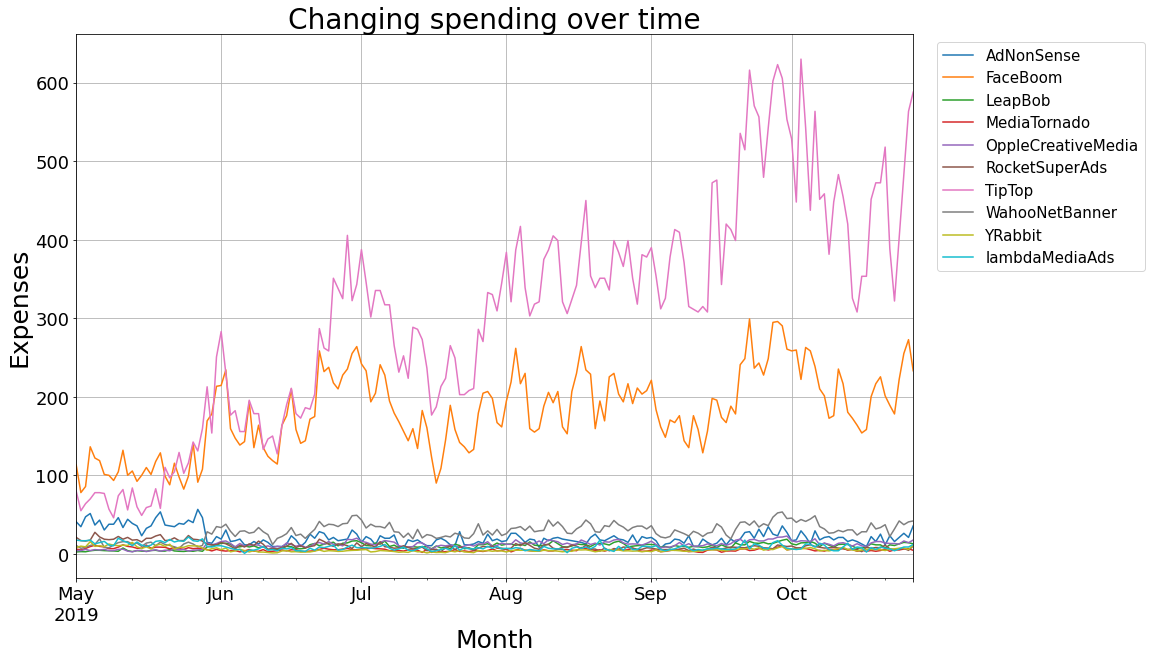

In [68]:
df_costs.pivot_table(
    index='dt',
    columns='channel',
    values='costs',  
    aggfunc='sum',  
).plot(figsize=(15, 10), grid=True, fontsize = 18)

plt.title('Changing spending over time', fontsize = 28)
plt.xlabel('Month', fontsize = 25)
plt.ylabel('Expenses', fontsize = 25)
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='best', fontsize = 15)
plt.show()

## 5.2. The average cost of attracting one buyer from each source.

**Let's exclude 'organic' acquisition channels from the user table, since their acquisition is free.**

In [69]:
profiles = profiles.query('channel!="organic"')

In [70]:
# find LTV broken down by acquisition channels
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, df_orders, observation_date, horizon_days, dimensions=dimensions
)

In [71]:
# find max acquisition date from raw LTV data
max_acquitision_dt = ltv_raw['dt'].max()
# cut profiles that are "older" than this date
ltv_profiles = profiles.query('dt <= @max_acquitision_dt')

# remaining number of users per lifetime
ltv_profiles.groupby('dt').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending = False).head(10)

user_id
dt                 
2019-09-29      859
2019-09-28      850
2019-09-27      777
2019-09-22      768
2019-09-30      764
2019-06-30      732
2019-10-04      731
2019-10-06      717
2019-10-03      712
2019-09-24      709

In [72]:
# average CAC by acquisition channel
cac = (
    ltv_profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
)
pd.options.display.float_format = '{:,.2f}'.format
cac

cac
channel                
AdNonSense         1.01
FaceBoom           1.11
LeapBob            0.21
MediaTornado       0.22
OppleCreativeMedia 0.25
RocketSuperAds     0.42
TipTop             2.76
WahooNetBanner     0.60
YRabbit            0.22
lambdaMediaAds     0.73

In [73]:
# average CAC across all sources
cac_total = (ltv_profiles.agg({'acquisition_cost': 'mean'}))
round(cac_total, 2)

acquisition_cost   1.12
dtype: float64

In [74]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 10), fontsize = 18)
plt.ylabel('CAC', fontsize = 25)
plt.xlabel('Engagement date', fontsize = 25)
plt.title('CAC dynamics by acquisition channels', fontsize = 28)
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='best', fontsize = 15)
plt.show()

## 5.3. Conclusion

The total amount of marketing expenses amounted to **105497.3**. The highest expenses were for the **TipTop channel - 54,751.3**. Every month **May to September**, marketing spending has been on the rise. A graph of spending over time showed that spending on TipTop increased every month. Spending on FaceBoom grew much more slowly. All other sources are significantly inferior in terms of marketing costs.

The acquisition cost of **organic users** across all channel cohorts is **zero** because they were not acquired through advertising. The most expensive users were on the **TipTop** channel. The cost per user cost the company an average of **2.76**. If for most channels the costs were approximately uniform throughout the entire time, then TipTop stands out significantly against their background, because. per-user spending has been on the rise almost every month. **Mean CAC** across all channels was **0.69**.

# 6. Estimate the ROI of ads to attract users

## 6.1. Analysis of the total advertising payback

In [75]:
# exclude organic users from the table
profiles = profiles.query('channel != "organic"')

In [76]:
# function to smooth the frame
def filter_data(df, window):
    # apply a moving average for each column
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [77]:
# function to visualize LTV and ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # set the grid for drawing charts
    plt.figure(figsize=(30, 15))

    # exclude cohort sizes from table ltv
    ltv = ltv.drop(columns=['cohort_size'])
    # leave only the desired lifetime in the ltv dynamics table
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # write the cost of attraction in a separate frame
    cac_history = roi_history[['cac']]

    # exclude cohort sizes and cac from table roi
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # leave only the desired lifetime in the roi dynamics table
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # first graph - ltv curves
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1, fontsize=23)
    plt.legend(fontsize=18, loc='best')
    plt.xlabel('Lifetime', fontsize=23)
    plt.title('LTV', fontsize=28)

    # second graph - ltv dynamics
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # all index columns except date will become pivot table columns
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Engagement date', fontsize=23)
    plt.legend(fontsize=18, loc='best')
    plt.title('User LTV dynamics on the {} day'.format(horizon), fontsize=28)

    # the third graph is the dynamics of cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # all index columns except date will become pivot table columns
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Engagement date', fontsize=23)
    plt.legend(fontsize=18, loc='best')
    plt.title('User Acquisition Cost Dynamics', fontsize=28)


    # fourth graph - roi curves
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4, fontsize=23)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.legend(fontsize=18, loc='best')
    plt.xlabel('Lifetime', fontsize=23)
    plt.title('ROI', fontsize=28)

    # the fifth graph is the dynamics of roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # all index columns except date will become pivot table columns
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.xlabel('Engagement date', fontsize=23)
    plt.legend(fontsize=18, loc='best')
    plt.title('Dynamics of ROI of users on the {}-th day'.format(horizon), fontsize=28)
    
    plt.tight_layout()
    plt.show()

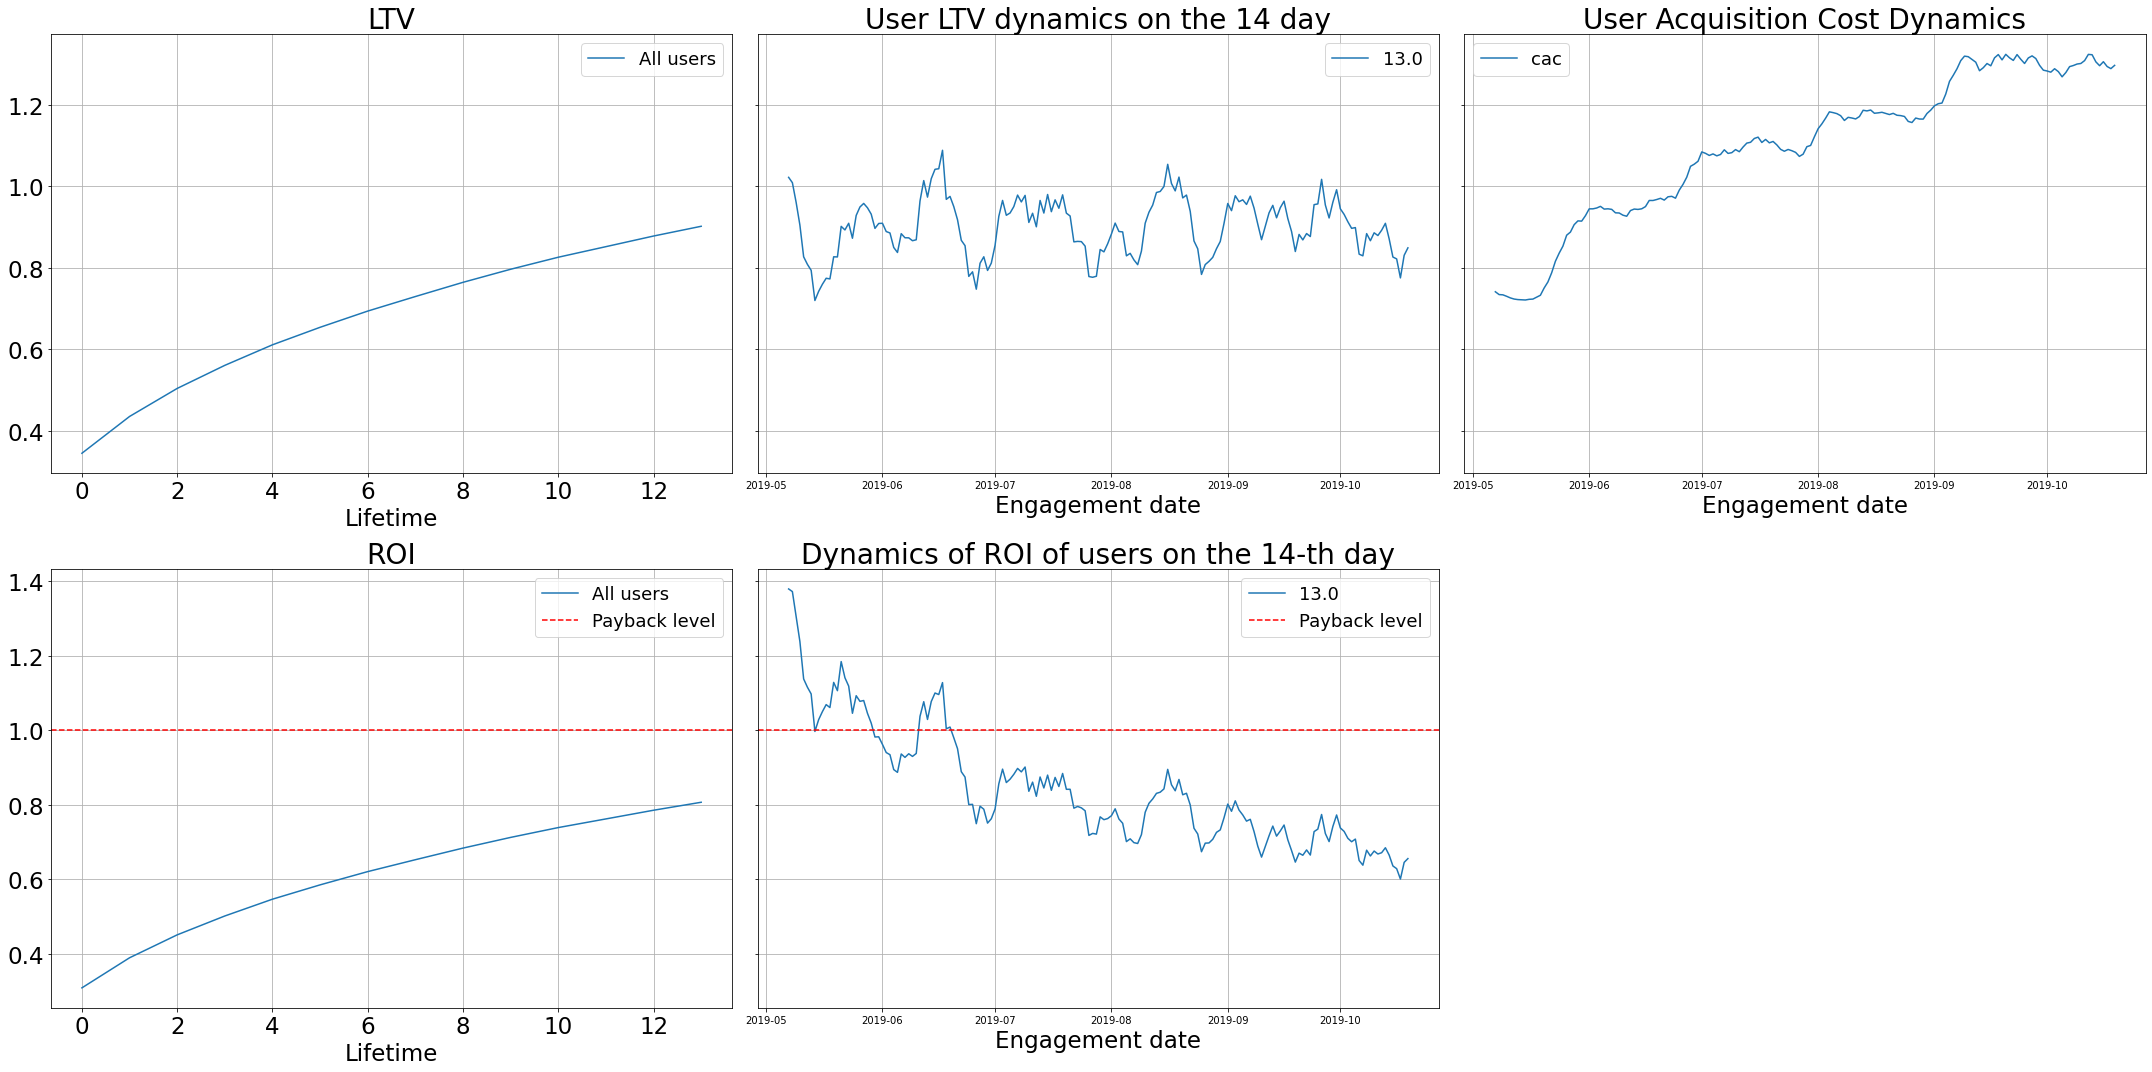

In [78]:
# calculate LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, df_orders, observation_date, horizon_days)

# build charts
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

### 6.1.1. Conclusion
From the graphs, we can conclude that the ROI is below the payback level. The ROI dynamics of users on the 14th day falls more and more over time. The dynamics of the cost of attracting users gradually increased. LTV is growing quite steadily.

## 6.2. Analysis of advertising ROI by channel

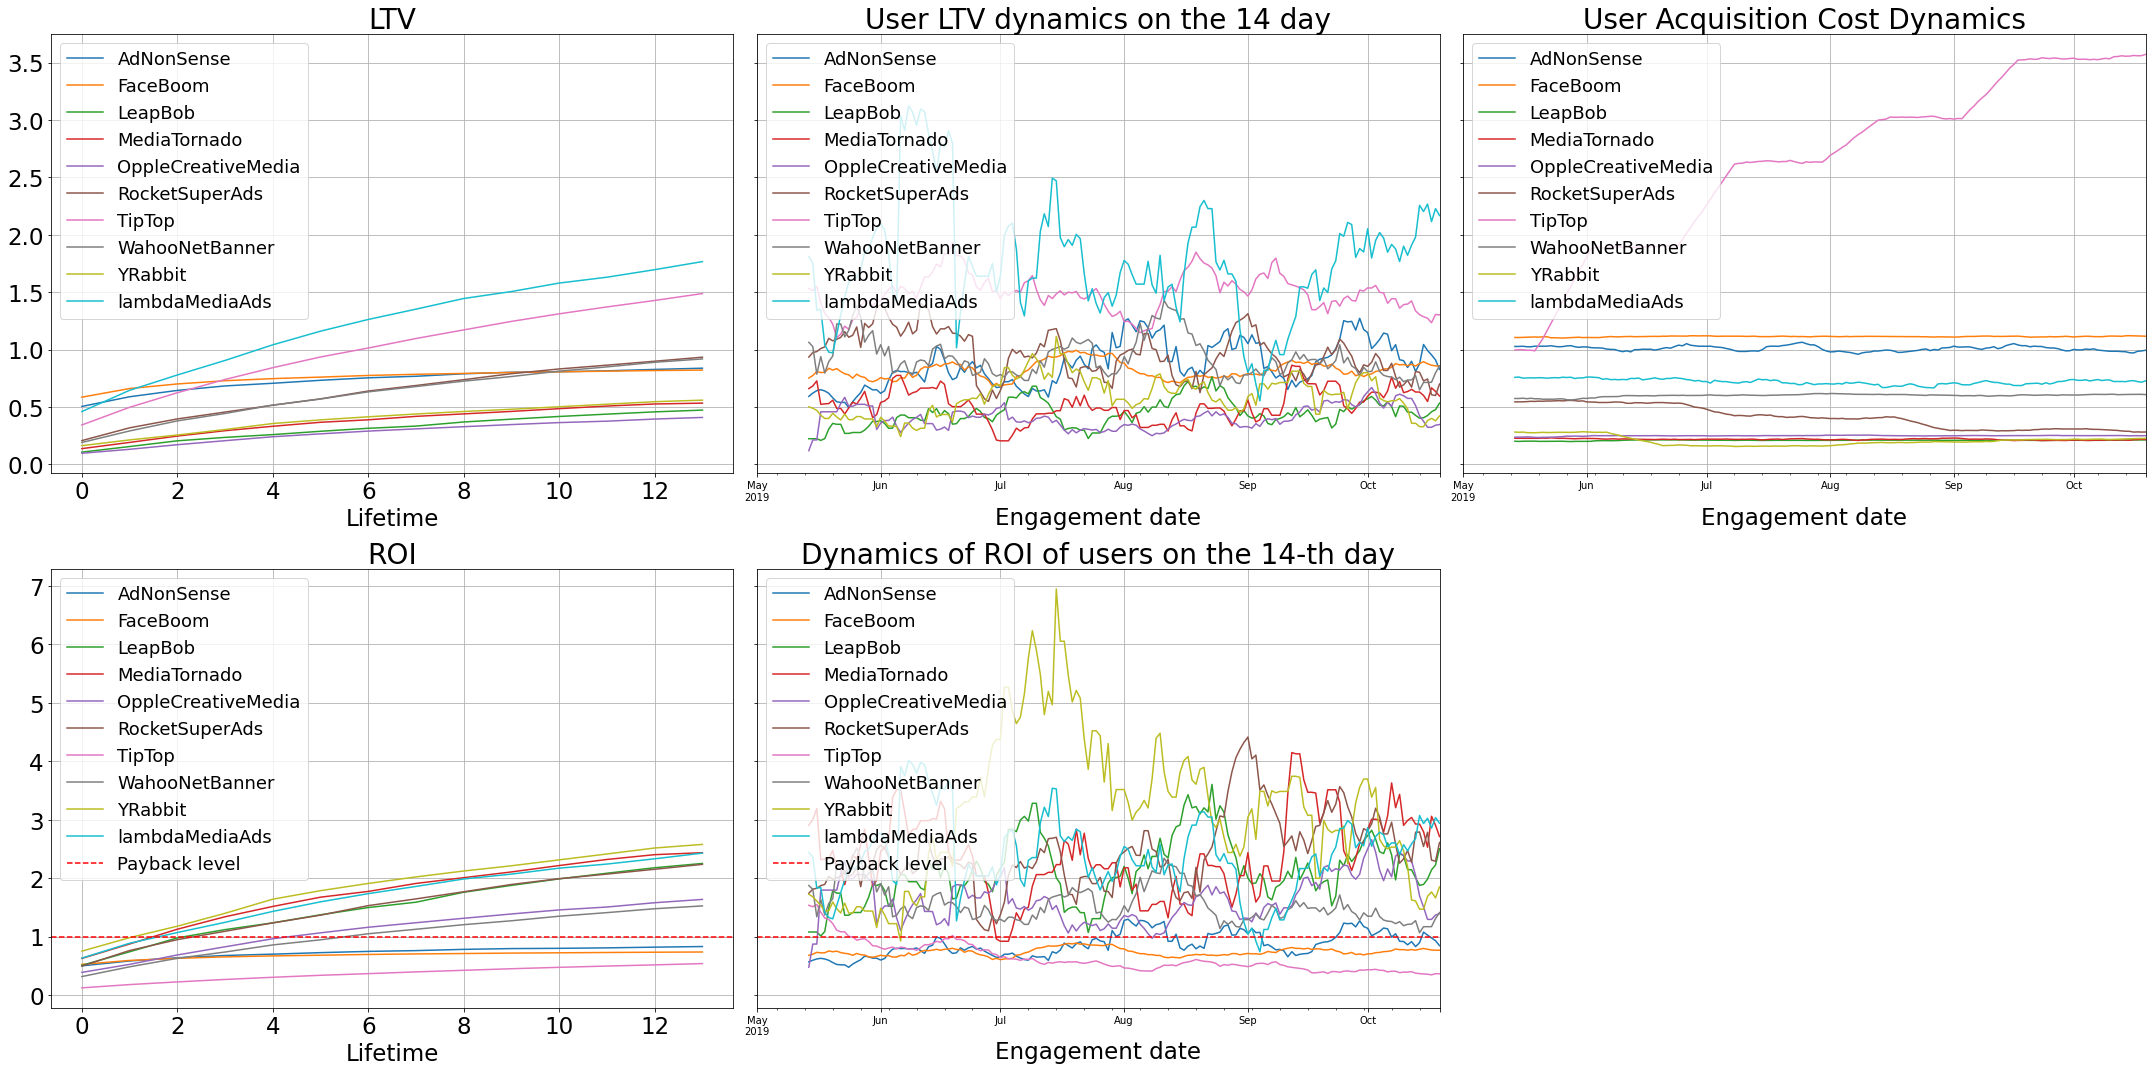

In [79]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, df_orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

### 6.2.1. Conclusion
The dynamics of the cost of attracting users is the highest for the **TipTop** channel. However, such investments did not lead to payback. The rest of the dynamics are stable. Out of 10 channels, only 3 are below the payback level, including TipTop.

## 6.3. Analysis of advertising ROI by country

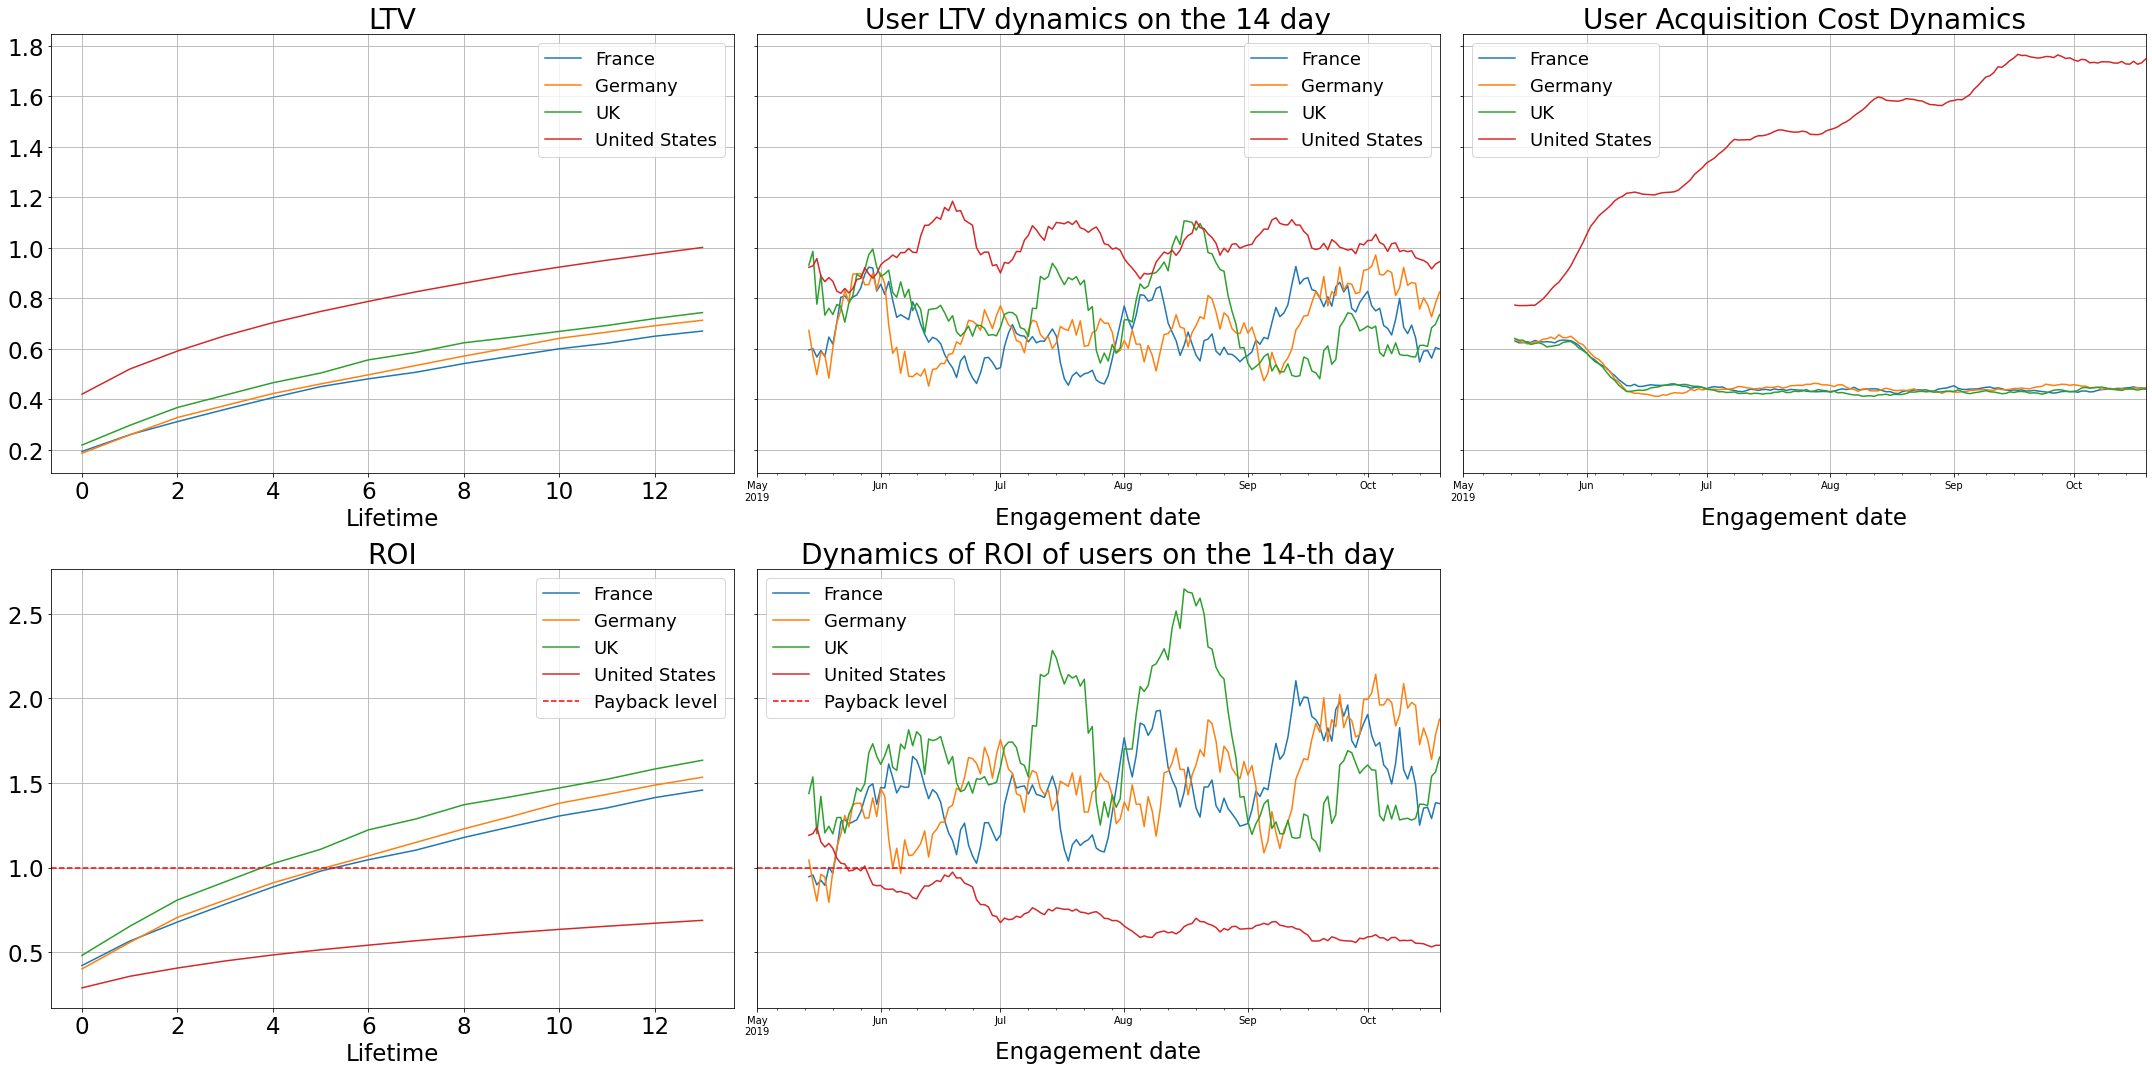

In [80]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, df_orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

### 6.3.1. Conclusion
Advertising did not pay off only in **USA**. **USA** has the highest growth in ad spend. Users from **England** have the highest ROI. **USA** has the highest LTV, but does not achieve payback.

Let's analyze the US market more carefully.

### 6.3.2 Ad ROI by device and advertising channel of US users.

In [81]:
# exclusion from the table of all countries except the USA
profiles_USA = profiles.query('region == "United States"')

**Sources of attraction**

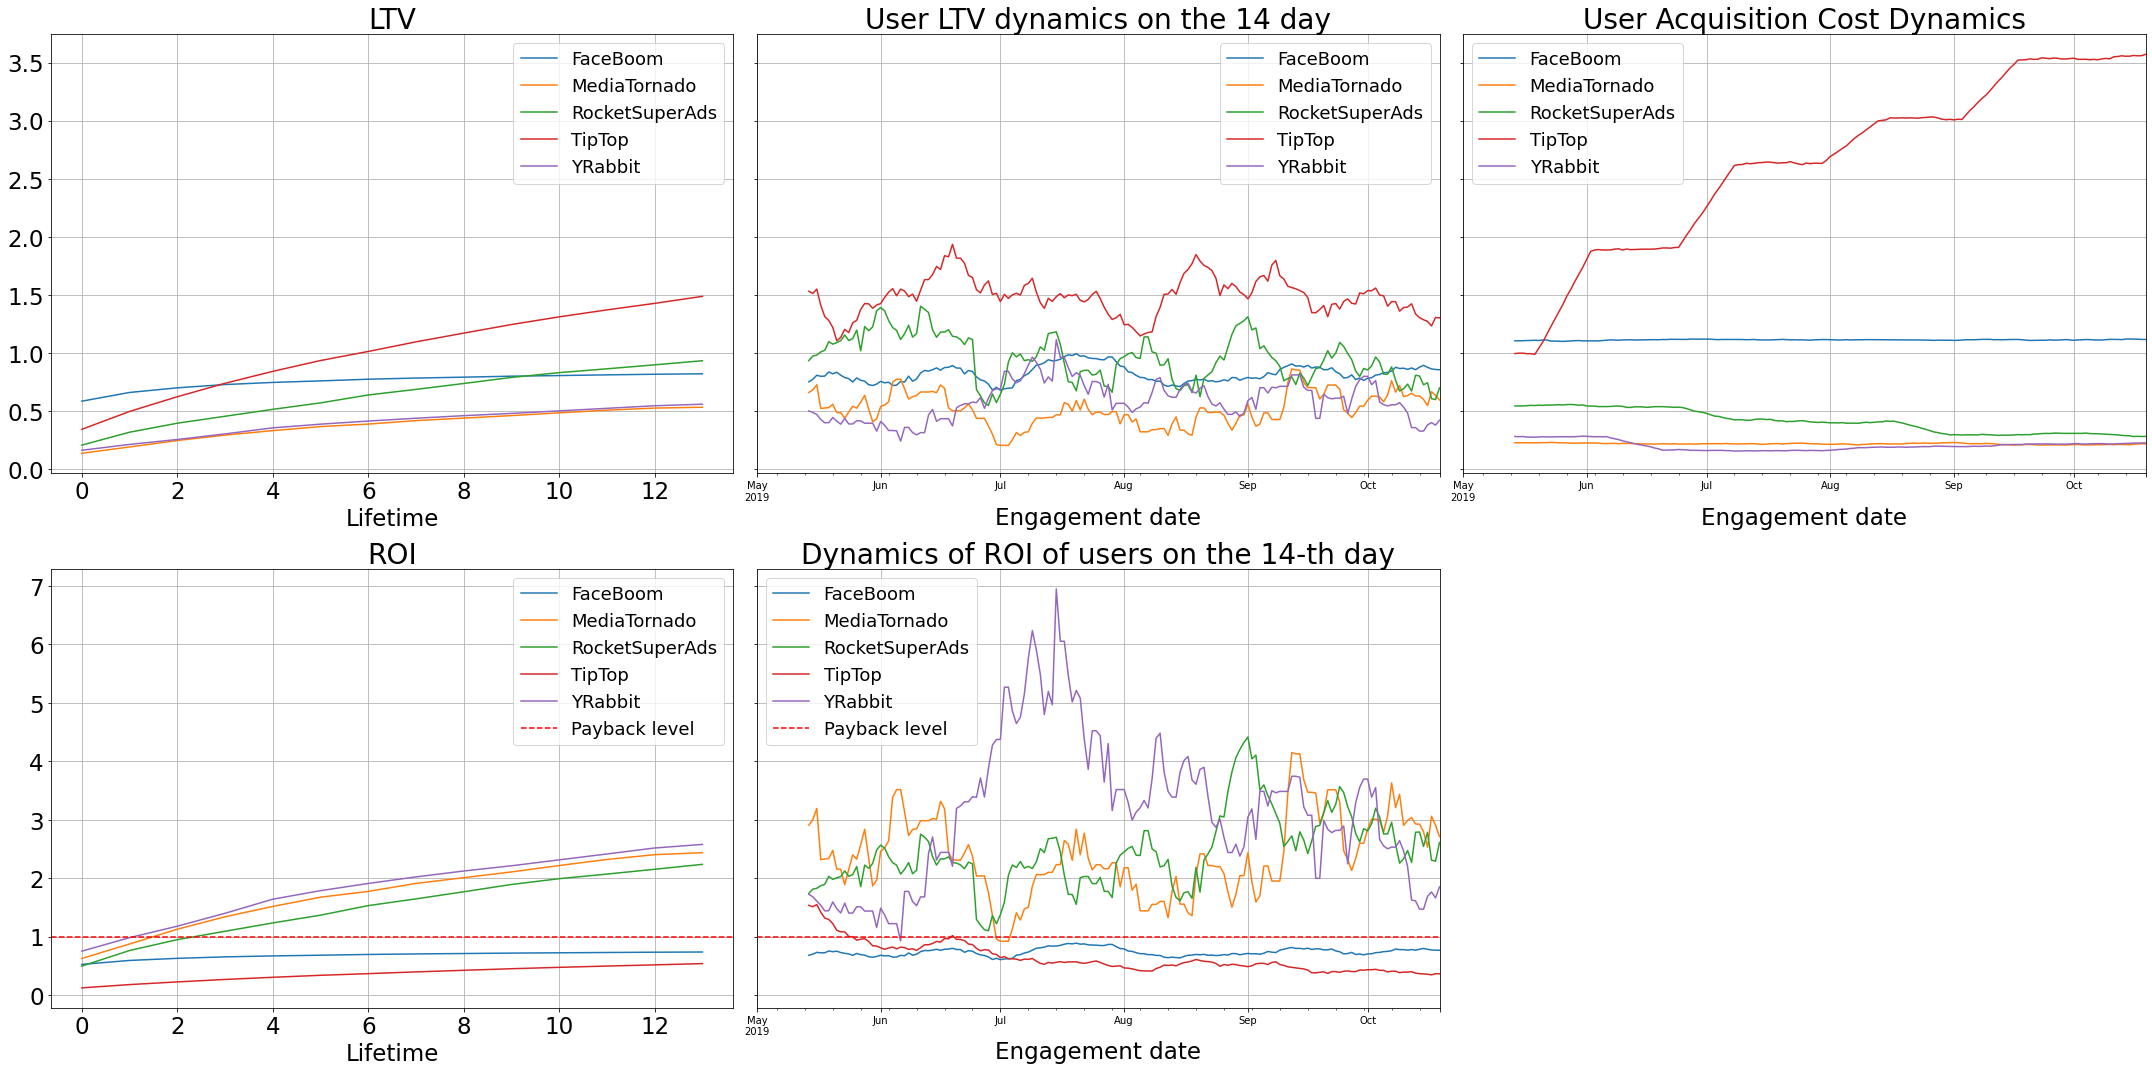

In [82]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_USA, df_orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Conclusion**

As you can see in the US, TipTop turned out to be the most unprofitable acquisition channel. Since this channel showed the highest income, this served as an excuse to spend exorbitant resources on advertising. However, such a large investment did not pay off in the end.

**Devices**

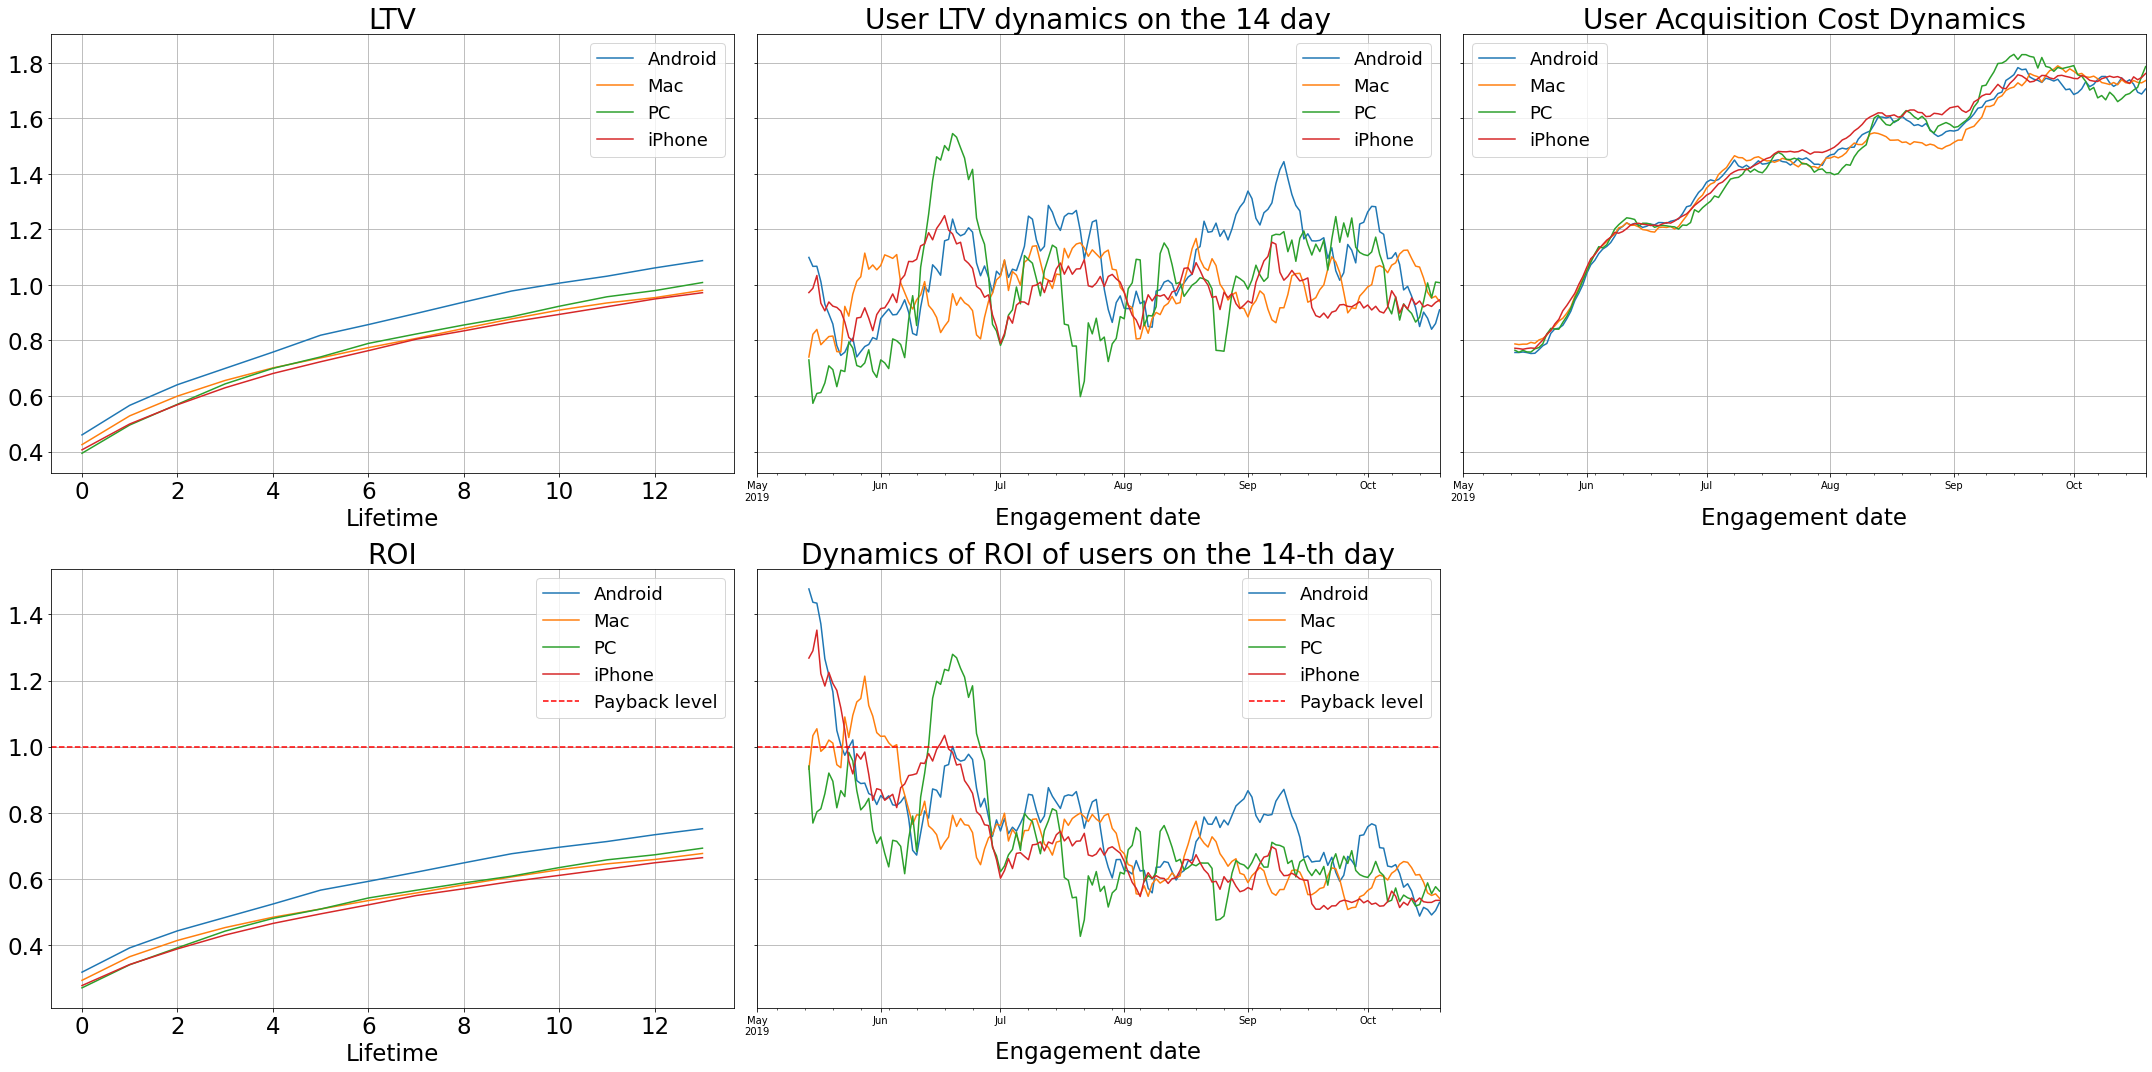

In [83]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_USA, df_orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Conclusion**

As you can see, none of the devices in the US ended up paying off. However, the Android platform generated the largest revenues. Probably on all devices there is some kind of bug in the application.

## 6.4. Ad ROI analysis by device

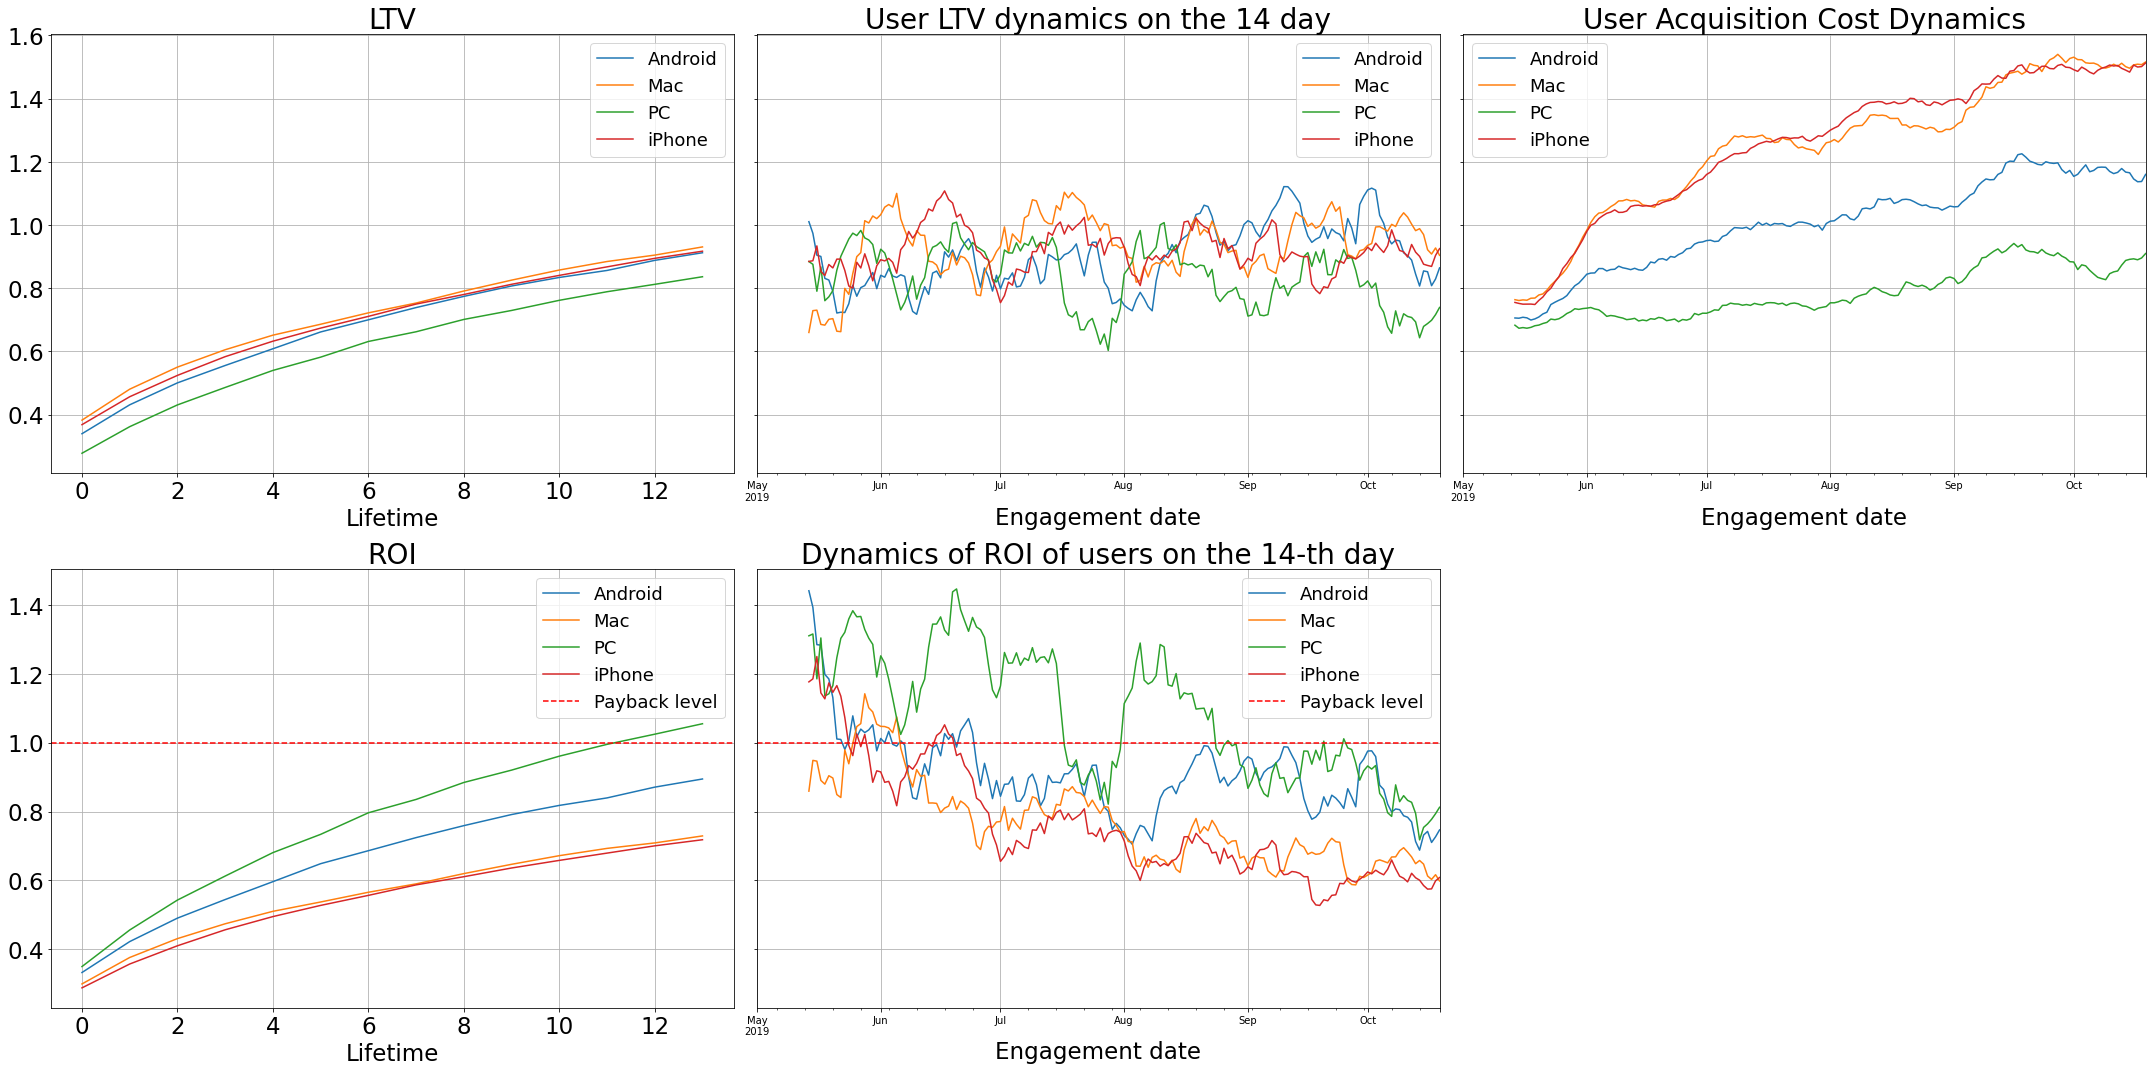

In [84]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, df_orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

### 6.4.1. Conclusion
Of all devices, only **PC** users pay off. The dynamics of the cost of customer acquisition shows that the lowest costs were in relation to **PC** users. The graph shows a decrease in the dynamics of ROI for all devices with an increase in the cost of attracting users.

# 7. Conversion and user retention by device, country and advertising channel.

**Function to visualize the conversion**

In [85]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # set the grid size for charts
    plt.figure(figsize=(30, 10))

    # exclude cohort sizes
    conversion = conversion.drop(columns=['cohort_size'])
    # leave only the desired lifetime in the dynamics table
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # first chart - conversion curves
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1, fontsize = 20)
    plt.legend()
    plt.xlabel('Lifetime', fontsize = 23)
    plt.title('User conversion', fontsize = 28)
    plt.legend(fontsize=18)

    # second graph - conversion dynamics
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # all index columns except date will become pivot table columns
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2, fontsize = 20)
    plt.xlabel('Engagement date', fontsize = 23)
    plt.title('Dynamics of user conversion on the {}-th day'.format(horizon), fontsize = 28)
    plt.legend(fontsize=18)

    plt.tight_layout()
    plt.show()

**Retention visualization feature**

In [92]:
def plot_retention(retention, retention_history, horizon, window=7):

    # set the grid size for charts
    plt.figure(figsize=(30, 20))

    # exclude cohort sizes and first day retention
    retention = retention.drop(columns=['cohort_size', 0])
    # leave only the desired lifetime in the dynamics table
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # if there is only payer in the indexes of the hold table,
    # add the second feature - cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

     # in the graph table - two columns and two rows, four cells
     # in the first we build retention curves for paying users
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1, fontsize = 20
    )
    plt.legend()
    plt.xlabel('Lifetime', fontsize = 23)
    plt.title('Retention of paying users', fontsize = 28)
    plt.legend(fontsize=18)

    # in the third cell - the dynamics of retention of paying
    
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    # get the column names for the pivot table
    
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # filter data and plot
    
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2, fontsize = 20)
    plt.xlabel('Engagement date', fontsize = 23)
    plt.legend(fontsize=18)
    plt.title(
        'Dynamics of retention of paying users on the {}-th day'.format(horizon), fontsize = 28
    )
    
    plt.tight_layout()
    plt.show() 

# 7.1. Analysis by device

### 7.1.1. Conversion

In [93]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, df_orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

### 7.1.2. Retention

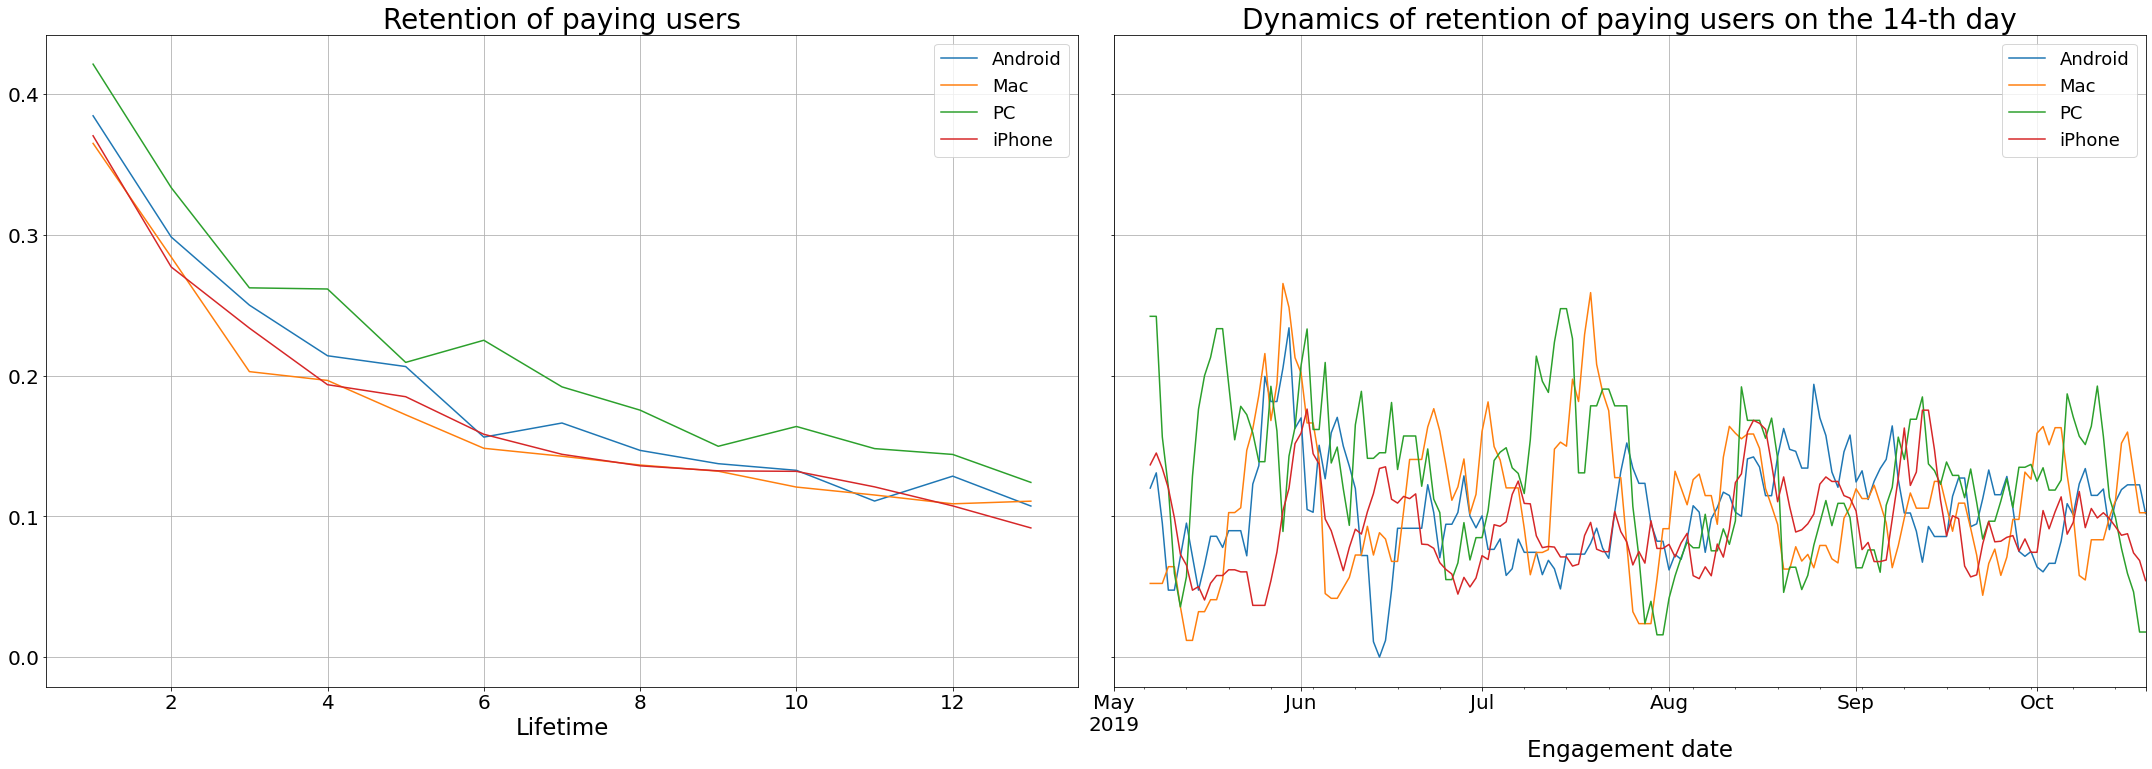

In [94]:
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, df_visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

### 7.1.3. Conclusion
**Mac and iPhone** users convert better than other devices. At the same time, in terms of user retention, **PC** shows the best results on average.

## 7.2. Analysis by region

### 7.2.1. Conversion

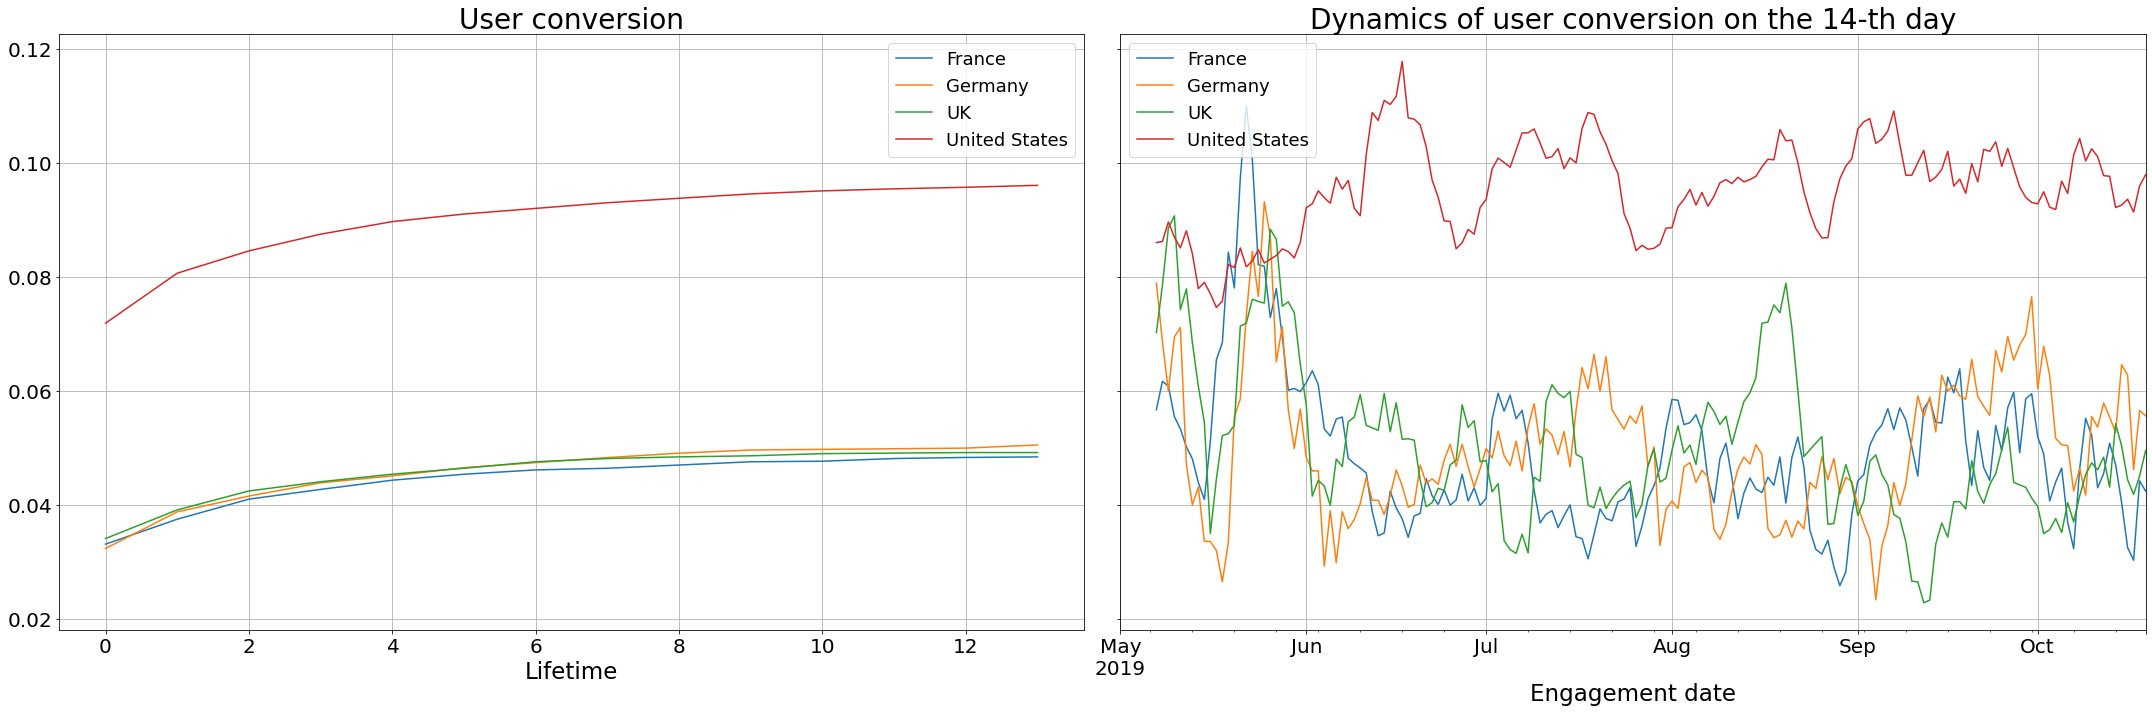

In [95]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, df_orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

### 7.2.2. Retention

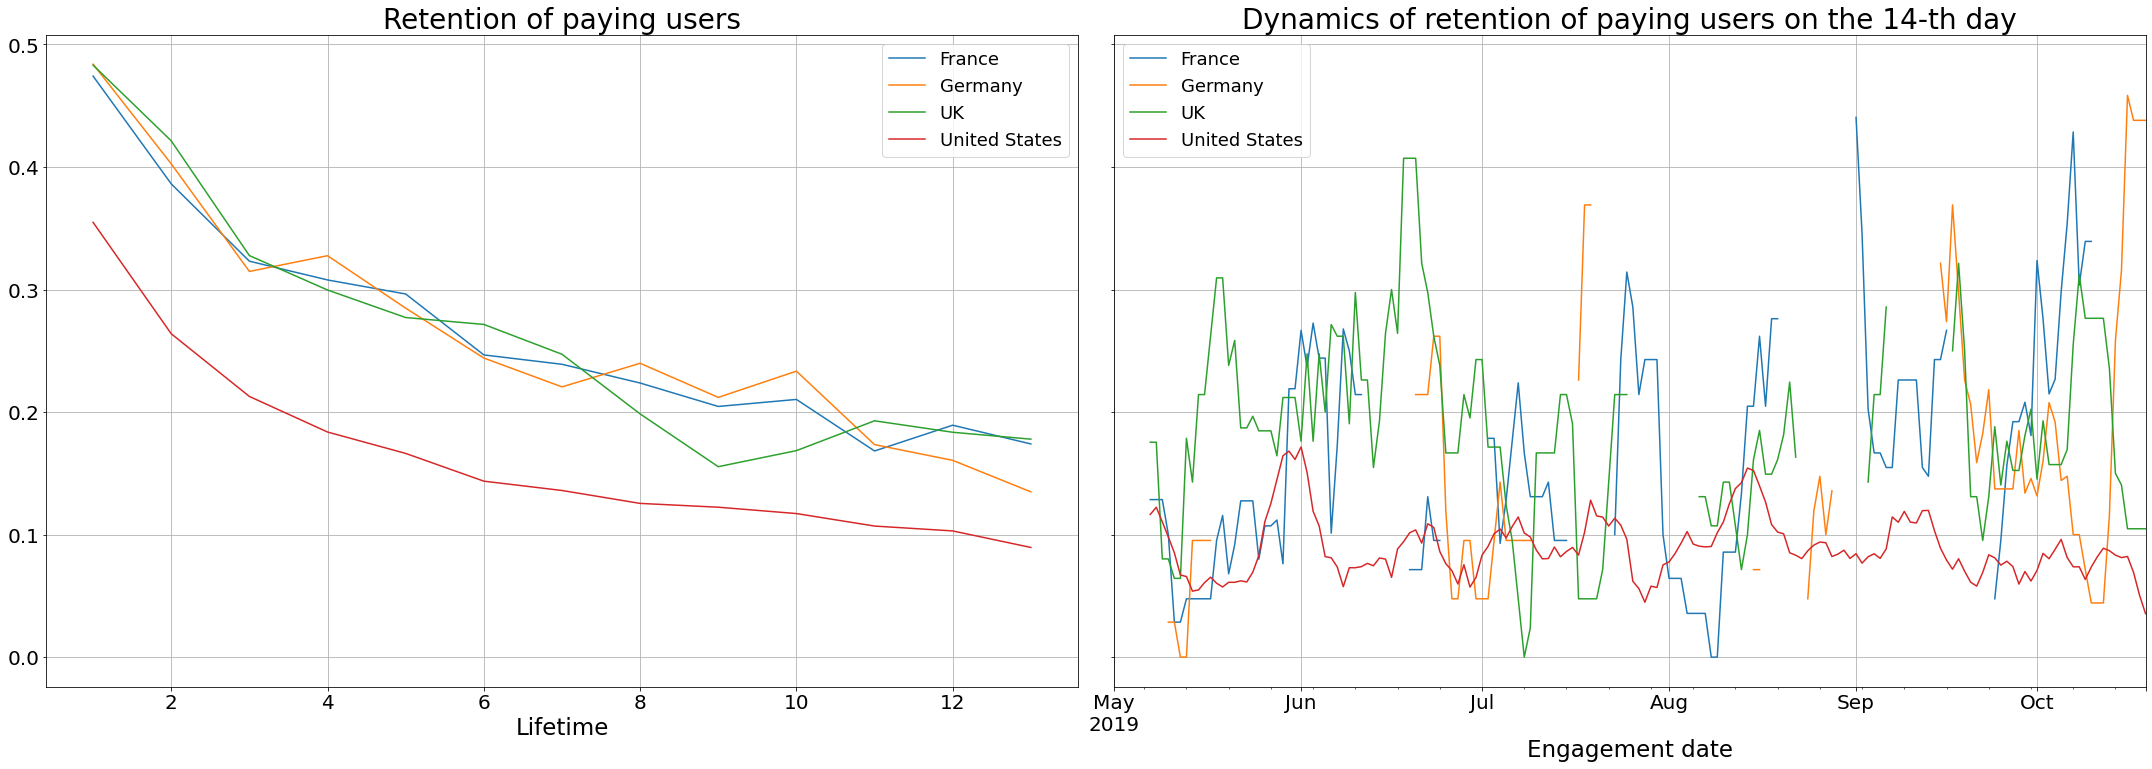

In [96]:
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, df_visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

### 7.2.3. Conclusion
When broken down by region, **US** is about **2** times ahead in conversions, but lags behind in user retention.

## 7.3. Analysis by channel

### 7.3.1. Conversion

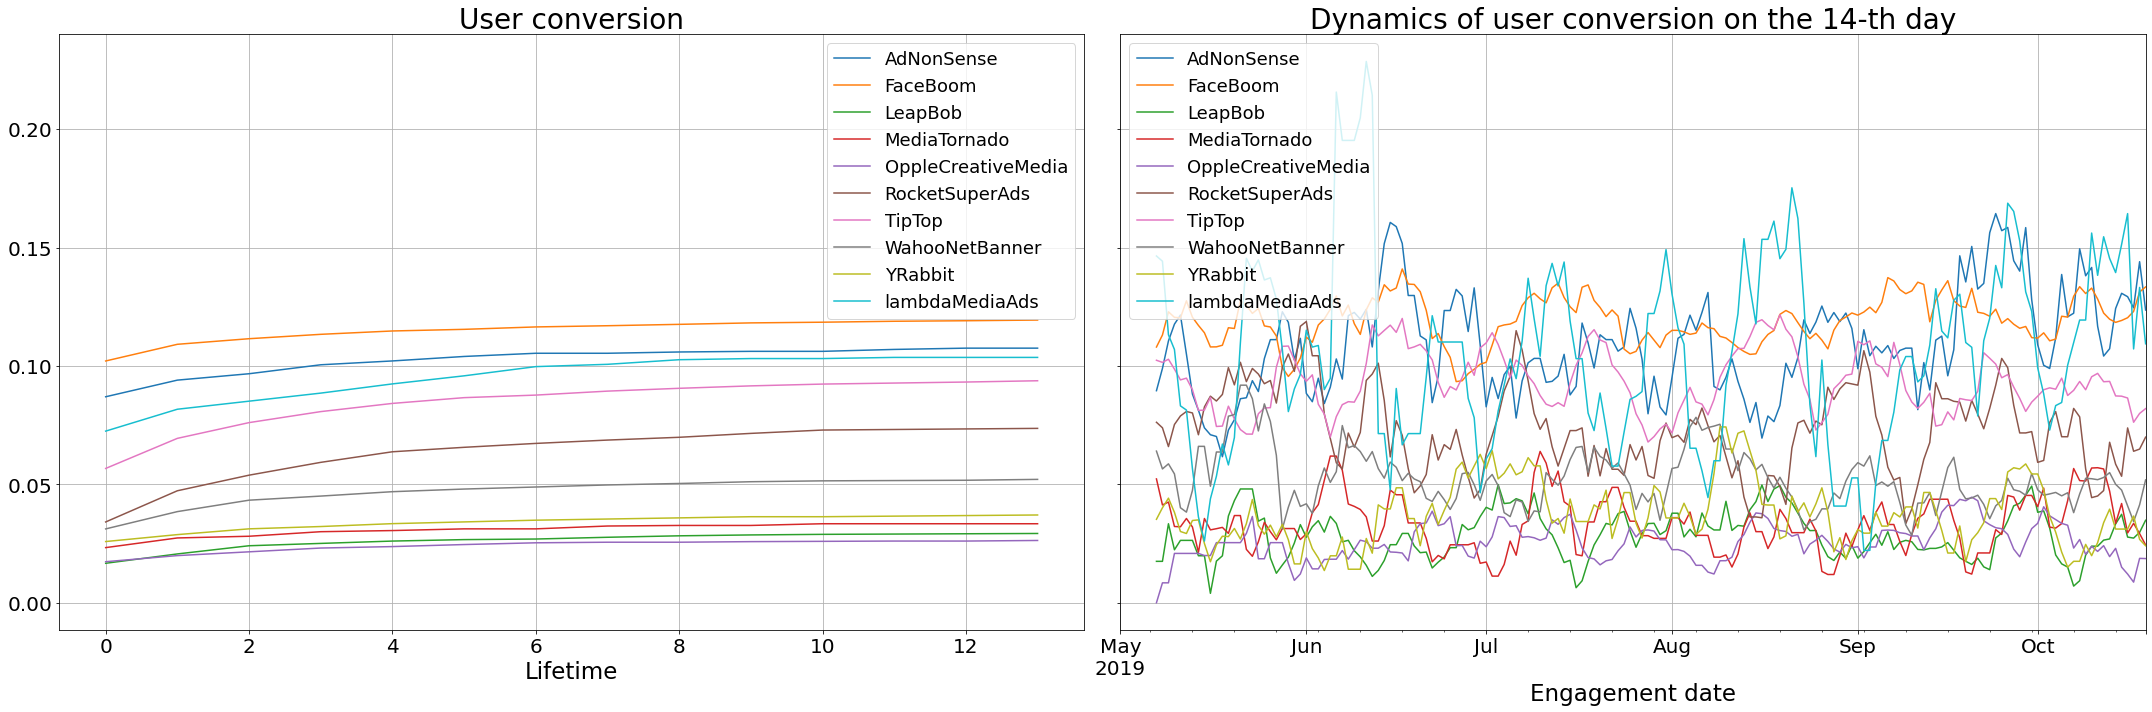

In [97]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, df_orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

### 7.3.2. Retention

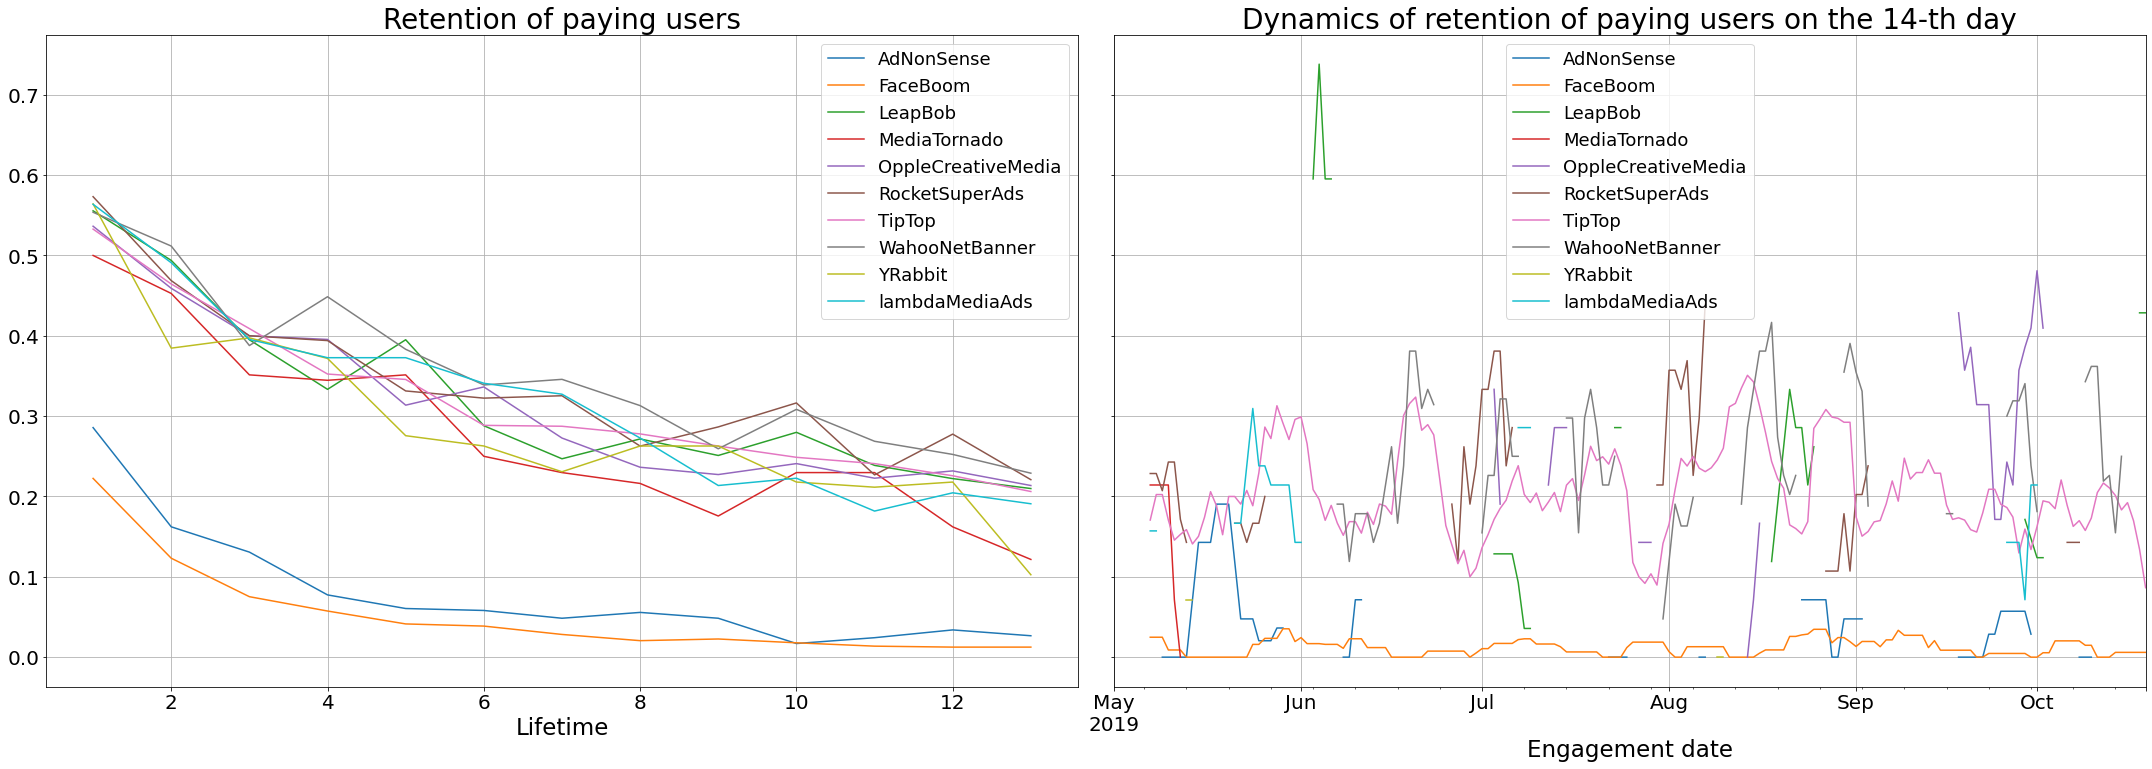

In [98]:
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, df_visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

### 7.3.3. Conclusion
With a breakdown by channel, users from **FaceBoom** are the worst retainers, while being ahead of the rest in terms of conversion.

# 8. General conclusion

In general, advertising ROI decreases over time. In the period under review, advertising ultimately did not pay off. When analyzing costs and ROI by country, device, and channel, it was found that excessive user acquisition costs were the cause of the issues identified.

In terms of devices, expenses paid off by PC users, by country - from France, Germany and the UK.

Of all the countries, the US was the only country that showed a loss in ROI. Increasing customer acquisition costs have not materialized.


In the context of devices, a decrease in the dynamics of payback by day 14 was revealed for all devices with an increase in the cost of attracting users. Mac and iPhone, as well as Android, performed below the payback level, while also showing the highest acquisition costs. In the US, users of all devices did not bring in enough money to make advertising on them pay off.

Excessive spending was found on the TipTop channel, which resulted in no positive ROI results.

The US is significantly ahead of other countries in terms of the number of users, incl. paying (about 100 thousand people in total). iPhone does not lead among devices, occupying the largest share. TipTop and FaceBoom are the most spending channels. Acquiring a single user from the TipTop channel cost the company an average of $2.76, with TipTop spending per user rising nearly every month.

YRabbit turned out to be the most effective acquisition channel, as it has the highest ROI, stable user retention over time, and at the same time, satisfied with low advertising costs.

**Procrastinate Pro+ Marketing Tips:**
*Recommended to reduce funding for ads on TipTop, FaceBoom and AdNonSense channels as none of them pay off;
* it is worth paying attention to the app's performance on all devices for the US market, since none of them paid off. Perhaps there are bugs or problems with payment. It can be seen that American users are the best at converting to paying ones, but almost immediately something prevents them from continuing to use the application (they leave the fastest);
* you should take a closer look at the YRabbit channel and increase advertising on it, as it is the most profitable, including in the USA;
* it is necessary to check the application on Mac devices, as users with these devices are the best at converting but the fastest to stop using applications (probably due to some kind of failures or errors);
* it is worth making the interface on PC devices more friendly so that users can convert better. On this device, people use the application for the longest time, and it also turned out to be the most profitable;
* it makes sense to increase advertising costs for users from England (they have the highest payback).